In [1]:
# import modules
import numpy as np
import pickle
import pandas as pd
from scipy.stats import norm

In [2]:
# initialisation (indexing for model retrieval)
num_reps = 100
config_ids = [36,37,38,39] # configuration ids of the optimal hyperparameter models
replication_ids = {}
failed_experiment_IDs = []

for index, config_id in enumerate(config_ids):
    experimentIDs = np.arange(index*num_reps+1,(index+1)*num_reps+1) # corresponding experiment IDs 
    # removing experiments that didn't run successfully
    experimentIDs = np.delete(experimentIDs,failed_experiment_IDs)
    replication_ids[config_id] = experimentIDs

In [3]:
# load appropriate data and obtain samples

# initialisation
date = '2025-02-04'
early_stopping = 100
root_dir = r"C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\experiments\hpc_runs\04-02-2025\model_test_data"
root_dir_model = r"C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\experiments\hpc_runs\04-02-2025\fit_models"
file_name_prefix = "long_experiment_"
file_name_suffix = f"_date_{date}_early_stopping_{early_stopping}"

In [4]:
return_variables = ['lon','lat','id','time','u','v','config_id','replication_id','mu_1','mu_2','sigma_11','sigma_22','sigma_12']
testing_data = pd.DataFrame(columns=return_variables)

In [5]:
for config_id in config_ids:
    for ii in range(num_reps):
        with open(fr'{root_dir}/{file_name_prefix}{replication_ids[config_id][ii]}{file_name_suffix}_test_data.p', 'rb') as pickle_file:
                    data = pickle.load(pickle_file)
                    data_df = data[0]
                    means = data[1][0]
                    covs = data[1][1]
                    # adding info
                    data_df['config_id'] = config_id
                    data_df['replication_id'] = ii
                    data_df['mu_1'], data_df['mu_2'] = means[:,0] , means[:,1] 
                    data_df['sigma_11'], data_df['sigma_22'], data_df['sigma_12'] = covs[:,0,0], covs[:,1,1], covs[:,0,1]
                    outvars = data_df[return_variables]
                    testing_data = pd.concat([testing_data,outvars],ignore_index=True)

C:\Users\vm2218\AppData\Local\Temp\ipykernel_22636\2865588473.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  testing_data = pd.concat([testing_data,outvars],ignore_index=True)


In [6]:
# add residuals
testing_data['e_1'] = testing_data['u']-testing_data['mu_1']
testing_data['e_2'] = testing_data['v']-testing_data['mu_2']

In [7]:
# angle off-set
testing_data['angle_offset'] = np.einsum('ij,ij->i',testing_data[['u','v']].values,testing_data[['mu_1','mu_2']].values)
testing_data['angle_offset'] = np.divide(testing_data['angle_offset'], np.multiply(
    np.linalg.norm(testing_data[['u','v']].values,axis=1),np.linalg.norm(testing_data[['mu_1','mu_2']].values,axis=1)
    ))
testing_data['angle_offset'] = np.clip(testing_data['angle_offset'],-1,1)
testing_data['angle_offset'] = np.arccos(testing_data['angle_offset'])
testing_data['angle_offset']=np.rad2deg(testing_data['angle_offset'])

In [8]:
filehandler = open(f"analysis_data.p","wb")
pickle.dump(testing_data,filehandler,protocol=pickle.HIGHEST_PROTOCOL)

# Global Evaluation

## Point Metrics (Prediction Accuracy)

In [9]:
# group by configuration id
point_analysis_data = testing_data.groupby(['config_id','replication_id'])[['lat','lon','id','time','u','v','config_id','replication_id','mu_1','mu_2','sigma_11','sigma_22','sigma_12','e_1','e_2','angle_offset']]

### Metrics for each replication

In [10]:
global_point_metrics_by_replication = pd.DataFrame(columns=['RMSE','MAE','MdAPE','MAAO'])

In [11]:
# calculate rmse over all data points for each replication
rmse_per_config = point_analysis_data.apply(lambda g: 100*np.sqrt(np.mean(g["e_1"]**2 + g["e_2"]**2)/2))
global_point_metrics_by_replication['RMSE']=rmse_per_config

In [12]:
# calculate mae over all data points for each replication
mae_per_config = point_analysis_data.apply(lambda g: 100*np.mean(np.abs(g["e_1"]) + np.abs(g["e_2"]))/2)
global_point_metrics_by_replication['MAE']=mae_per_config

In [13]:
# calculate maao over all data points for each replication
maao_per_config = point_analysis_data.apply(lambda g: np.mean(g['angle_offset']))
global_point_metrics_by_replication['MAAO']=maao_per_config

In [14]:
# calculate medAPE over all data points for each replication
mdAPE_per_config = point_analysis_data.apply(lambda g: np.median([100*np.abs(g["e_1"]/g["u"]), 100*np.abs(g["e_2"]/g["v"])]))
global_point_metrics_by_replication['MdAPE']=mdAPE_per_config

In [15]:
global_point_metrics_by_replication_data = global_point_metrics_by_replication.groupby('config_id')[['RMSE','MAE','MdAPE','MAAO']]

In [16]:
global_point_metrics_by_replication

RMSE        MAE      MdAPE       MAAO
config_id replication_id                                            
36        0               14.637541   9.852936  66.080252  40.820104
          1               14.723423   9.925735  65.559610  39.712297
          2               14.562164   9.821444  65.194768  40.082736
          3               15.107037  10.309083  66.898909  40.637668
          4               14.428255   9.725741  67.619112  41.490144
...                             ...        ...        ...        ...
39        95              14.152587   9.649509  66.233602  40.071270
          96              14.518828   9.820072  64.930363  39.732634
          97              14.789399   9.990455  64.201933  39.491352
          98              15.329971  10.304926  65.095423  40.107992
          99              14.396832   9.812459  65.761084  40.445346

[400 rows x 4 columns]

### Summary of Point Metrics

In [17]:
global_point_metrics_summaries = pd.DataFrame(columns=['RMSE mean','RMSE std', 'MAE mean', 'MAE std','MdAPE mean', 'MdAPE std','MAAO mean', 'MAAO std'])

In [18]:
point_metric_names = ['RMSE','MAE','MdAPE','MAAO']

In [19]:
for name in point_metric_names:
    mean = global_point_metrics_by_replication_data.apply(lambda g: np.mean(g[name]))
    std = global_point_metrics_by_replication_data.apply(lambda g: np.std(g[name],ddof=1))
    global_point_metrics_summaries[f'{name} mean']=mean
    global_point_metrics_summaries[f'{name} std']=std

In [20]:
global_point_metrics_summaries

,RMSE mean,RMSE std,MAE mean,MAE std,MdAPE mean,MdAPE std,MAAO mean,MAAO std
config_id,,,,,,,,
36,14.783894,0.459634,9.964375,0.303359,66.159957,0.948322,40.485154,0.708520
37,14.750128,0.460359,9.959707,0.302851,65.976940,0.941905,40.490486,0.722616
38,14.542571,0.454691,9.843939,0.300715,65.546610,0.955865,40.079249,0.715063
39,14.533736,0.456756,9.856823,0.302589,65.480731,0.920441,40.115957,0.714580


## Distribution Metrics (Prediction Accuracy)


### Metrics for Each Replication

In [21]:
def compute_nll(group):
    sigma_11 = group["sigma_11"]
    sigma_22 = group["sigma_22"]
    sigma_12 = group["sigma_12"]

    # Determinant of covariance matrix
    det_sigma = sigma_11 * sigma_22 - sigma_12 ** 2
    log_det_sigma = np.log(det_sigma)

    # Inverse of covariance matrix
    inv_sigma_11 = sigma_22 / det_sigma
    inv_sigma_22 = sigma_11 / det_sigma
    inv_sigma_12 = -sigma_12 / det_sigma

    # Compute quadratic term (Mahalanobis distance)
    e1, e2 = group["e_1"], group["e_2"]
    mahalanobis = (inv_sigma_11 * e1**2 + inv_sigma_22 * e2**2 + 2 * inv_sigma_12 * e1 * e2)

    # Compute NLL
    nll = 0.5 * (log_det_sigma + mahalanobis + np.log(4 * np.pi**2))
    return np.mean(nll)

def compute_crps(group):
    # Compute univariate CRPS for both velocity components
    def univariate_crps(e, sigma):
        std_norm_cdf = norm.cdf(e / sigma)
        return sigma * (1 - (2 / np.sqrt(np.pi)) * np.exp(-0.5 * (e / sigma) ** 2)) + e * (2 * std_norm_cdf - 1)

    crps_1 = univariate_crps(group["e_1"], np.sqrt(group["sigma_11"]))
    crps_2 = univariate_crps(group["e_2"], np.sqrt(group["sigma_22"]))

    return np.mean(crps_1 + crps_2) / 2  # Average over both dimensions


In [22]:
global_distributional_metrics_by_replication = pd.DataFrame(columns=['NLL','CRPS'])

In [23]:
# calculate nll over all data points for each replication
nll_per_config = point_analysis_data.apply(compute_nll)
global_distributional_metrics_by_replication['NLL']=nll_per_config

In [24]:
crps_per_config = point_analysis_data.apply(compute_crps)
global_distributional_metrics_by_replication['CRPS']=crps_per_config

In [25]:
global_distributional_metrics_by_replication

NLL      CRPS
config_id replication_id                    
36        0              -1.440711  0.096162
          1              -1.417110  0.095801
          2              -1.453664  0.095730
          3              -1.323430  0.102190
          4              -1.457378  0.095266
...                            ...       ...
39        95             -1.494421  0.094107
          96             -1.442614  0.096159
          97             -1.402807  0.098442
          98             -1.353397  0.101515
          99             -1.440339  0.095419

[400 rows x 2 columns]

### Summary of Distributional Metrics

In [26]:
distributional_metric_names = ['NLL','CRPS']
global_distributional_metrics_by_replication_data = global_distributional_metrics_by_replication.groupby('config_id')
global_distributional_metrics_summaries = pd.DataFrame(columns=['NLL mean', 'NLL std', 'CRPS mean', 'CRPS std'])

In [27]:
for name in distributional_metric_names:
    mean = global_distributional_metrics_by_replication_data.apply(lambda g: np.mean(g[name]))
    std = global_distributional_metrics_by_replication_data.apply(lambda g: np.std(g[name],ddof=1))
    global_distributional_metrics_summaries[f'{name} mean']=mean
    global_distributional_metrics_summaries[f'{name} std']=std

In [28]:
global_distributional_metrics_summaries

,NLL mean,NLL std,CRPS mean,CRPS std
config_id,,,,
36,-1.415170,0.066092,0.097287,0.003403
37,-1.411582,0.064721,0.096986,0.003326
38,-1.446656,0.065444,0.096549,0.003404
39,-1.441489,0.064162,0.096528,0.003346


## Calibration

In [39]:
import scipy
def in_cr(sigma_11,sigma_12,sigma_22,e1,e2,alpha=0.90):

    crit_val = scipy.stats.chi2.ppf(alpha, 2)  # Chi-square threshold for 2D case
    det_sigma = sigma_11 * sigma_22 - sigma_12**2  # Determinant of Σ

    # Explicit inverse of Σ
    sigma_inv_11 = sigma_22 / det_sigma
    sigma_inv_12 = -sigma_12 / det_sigma
    sigma_inv_22 = sigma_11 / det_sigma

    # Compute Mahalanobis distance squared
    n = (
        e1 * (sigma_inv_11 * e1 + sigma_inv_12 * e1) +
        e2 * (sigma_inv_12 * e2 + sigma_inv_22 * e2)
    )

    return n < crit_val

def compute_coverage(group):

    sigma_11 = group["sigma_11"]
    sigma_22 = group["sigma_22"]
    sigma_12 = group["sigma_12"]

    e1 = group["e_1"]
    e2 = group["e_2"]

    proportions = in_cr(sigma_11,sigma_12,sigma_22,e1,e2)

    return np.mean(np.sum(proportions)/len(proportions))

def matrix_area(sigma_11, sigma_12, sigma_22, alpha=0.9):
    chi2_val = scipy.stats.chi2.ppf(alpha, 2) 
    det_sigma = sigma_11 * sigma_22 - sigma_12**2

    return np.pi * chi2_val * np.sqrt(det_sigma)

def compute_area(group):

    sigma_11 = group["sigma_11"]
    sigma_22 = group["sigma_22"]
    sigma_12 = group["sigma_12"]

    return np.mean(matrix_area(sigma_11, sigma_12, sigma_22))

In [40]:
global_calibration_metrics_by_replication = pd.DataFrame(columns=['PR Area','PR Coverage'])

In [41]:
prediction_region_coverage = point_analysis_data.apply(compute_coverage)
prediction_region_area = point_analysis_data.apply(compute_area)

In [45]:
global_calibration_metrics_by_replication['PR Area'] = prediction_region_area*100**2
global_calibration_metrics_by_replication['PR Coverage'] = prediction_region_coverage

In [46]:
global_calibration_metrics_by_replication

PR Area  PR Coverage
config_id replication_id                          
36        0               2396.192442     0.864525
          1               2541.936084     0.867349
          2               2414.672441     0.862572
          3               2493.740011     0.853727
          4               2297.515001     0.861904
...                               ...          ...
39        95              2283.131864     0.864793
          96              2326.613618     0.861423
          97              2350.373873     0.856907
          98              2508.505940     0.858259
          99              2404.123406     0.866158

[400 rows x 2 columns]

In [48]:
calibration_metric_names = ['PR Area','PR Coverage']
summary_names = ['PR Area mean', 'PR Area std', 'PR Coverage mean', 'PR Coverage std']
global_calibration_metrics_by_replication_data = global_calibration_metrics_by_replication.groupby('config_id')
global_calibration_metrics_summaries = pd.DataFrame(columns=summary_names)

In [49]:
for name in calibration_metric_names:
    mean = global_calibration_metrics_by_replication_data.apply(lambda g: np.mean(g[name]))
    std = global_calibration_metrics_by_replication_data.apply(lambda g: np.std(g[name],ddof=1))
    global_calibration_metrics_summaries[f'{name} mean']=mean
    global_calibration_metrics_summaries[f'{name} std']=std

In [50]:
global_calibration_metrics_summaries

,PR Area mean,PR Area std,PR Coverage mean,PR Coverage std
config_id,,,,
36,2456.240423,121.128369,0.864836,0.005833
37,2498.146264,127.154562,0.864606,0.005332
38,2302.460886,110.232054,0.861612,0.005455
39,2361.711605,267.903977,0.861168,0.005290


## Model Fit

In [66]:
fit_names = ['Studentised e_1', 'Studentised e_2']
studentised_residuals = pd.DataFrame(columns=[fit_names])

In [67]:
studentised_e1_per_config = point_analysis_data.apply(lambda g: g["e_1"]/np.sqrt(g["sigma_11"]))
studentised_e2_per_config = point_analysis_data.apply(lambda g: g["e_2"]/np.sqrt(g["sigma_22"]))
studentised_residuals['Studentised e_1'] = studentised_e1_per_config
studentised_residuals['Studentised e_2'] = studentised_e2_per_config

In [70]:
studentised_residuals

Studentised e_1 Studentised e_2
config_id replication_id                                         
36        0              0              -0.735459        0.587948
                         1              -0.949251        0.626699
                         2              -0.815252        1.074595
                         3              -0.086197        0.780358
                         4               0.415942        1.537305
...                                           ...             ...
39        99             16479735        0.226709        0.134135
                         16479736        0.616115        0.594142
                         16479737        0.975459        0.189468
                         16479738        1.398583       -0.638252
                         16479739        0.645716       -1.353895

[16479740 rows x 2 columns]

In [72]:
fit_names = ['R2 Score']
global_model_fit_metrics_by_replication = pd.DataFrame(columns=[fit_names])

In [73]:
rss = point_analysis_data.apply(lambda g: np.sum(g['e_1']**2+ g['e_2']**2))
tss = point_analysis_data.apply(lambda g: np.sum((g['u']-np.mean(g['u']))**2+(g['v']-np.mean(g['v']))**2))
r2_score_per_config =  1-rss/tss
global_model_fit_metrics_by_replication['R2 Score'] = r2_score_per_config

In [74]:
global_model_fit_metrics_by_replication

R2 Score
config_id replication_id          
36        0               0.641996
          1               0.644423
          2               0.652937
          3               0.633165
          4               0.632705
...                            ...
39        95              0.640149
          96              0.654236
          97              0.654744
          98              0.654505
          99              0.656965

[400 rows x 1 columns]

In [76]:
summary_names = ['R2 Score mean', 'R2 Score std']
global_model_fit_metrics_by_replication_data = global_model_fit_metrics_by_replication.groupby('config_id')
global_model_fit_metrics_summaries = pd.DataFrame(columns=summary_names)

In [77]:
name = 'R2 Score'
mean = global_model_fit_metrics_by_replication_data.apply(lambda g: np.mean(g[name]))
std = global_model_fit_metrics_by_replication_data.apply(lambda g: np.std(g[name],ddof=1))
global_model_fit_metrics_summaries[f'{name} mean']=mean
global_model_fit_metrics_summaries[f'{name} std']=std

c:\Users\vm2218\AppData\Local\anaconda3\envs\SeaDucks\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [78]:
global_model_fit_metrics_summaries

,R2 Score mean,R2 Score std
config_id,,
36,0.641714,0.011580
37,0.643349,0.011619
38,0.653306,0.011606
39,0.653737,0.011419


## Assumption Validity

In [79]:
def compute_mahalanobis(group):
    sigma_11 = group["sigma_11"]
    sigma_22 = group["sigma_22"]
    sigma_12 = group["sigma_12"]

    # Determinant of covariance matrix
    det_sigma = sigma_11 * sigma_22 - sigma_12 ** 2

    # Inverse of covariance matrix
    inv_sigma_11 = sigma_22 / det_sigma
    inv_sigma_22 = sigma_11 / det_sigma
    inv_sigma_12 = -sigma_12 / det_sigma

    # Compute quadratic term (Mahalanobis distance)
    e1, e2 = group["e_1"], group["e_2"]
    mahalanobis = (inv_sigma_11 * e1**2 + inv_sigma_22 * e2**2 + 2 * inv_sigma_12 * e1 * e2)
    
    return np.mean(mahalanobis)

In [80]:
fit_names = ['Mahalanobis Distance']
global_assumption_validation_by_replication = pd.DataFrame(columns=[fit_names])

In [81]:
mahalanobis_per_config = point_analysis_data.apply(compute_mahalanobis)
global_assumption_validation_by_replication['Mahalanobis Distance'] = mahalanobis_per_config

In [82]:
global_assumption_validation_by_replication

Mahalanobis Distance
config_id replication_id                     
36        0                          2.358661
          1                          2.329770
          2                          2.385065
          3                          2.537769
          4                          2.406284
...                                       ...
39        95                         2.355051
          96                         2.415035
          97                         2.470460
          98                         2.478514
          99                         2.380771

[400 rows x 1 columns]

In [83]:
summary_names = ['Mahalanobis Distance mean', 'Mahalanobis Distance std']
global_assumption_validation_by_replication_data = global_assumption_validation_by_replication.groupby('config_id')
global_assumption_validation_summaries = pd.DataFrame(columns=summary_names)

In [85]:
name = 'Mahalanobis Distance'
mean = global_assumption_validation_by_replication_data.apply(lambda g: np.mean(g[name]))
std = global_assumption_validation_by_replication_data.apply(lambda g: np.std(g[name],ddof=1))
global_assumption_validation_summaries[f'{name} mean']=mean
global_assumption_validation_summaries[f'{name} std']=std

c:\Users\vm2218\AppData\Local\anaconda3\envs\SeaDucks\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [86]:
global_assumption_validation_summaries

,Mahalanobis Distance mean,Mahalanobis Distance std
config_id,,
36,2.384491,0.072408
37,2.393974,0.063832
38,2.398763,0.065558
39,2.409659,0.062473


# Diagnostic Plots

In [87]:
import matplotlib.pyplot as plt
import scipy.stats
# configure plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
plt.style.use('ggplot')

1. Mahalanobis distance Q-Q plot: Checking the assumption that $Y|X$ follows a multivariate Gaussian distribution.

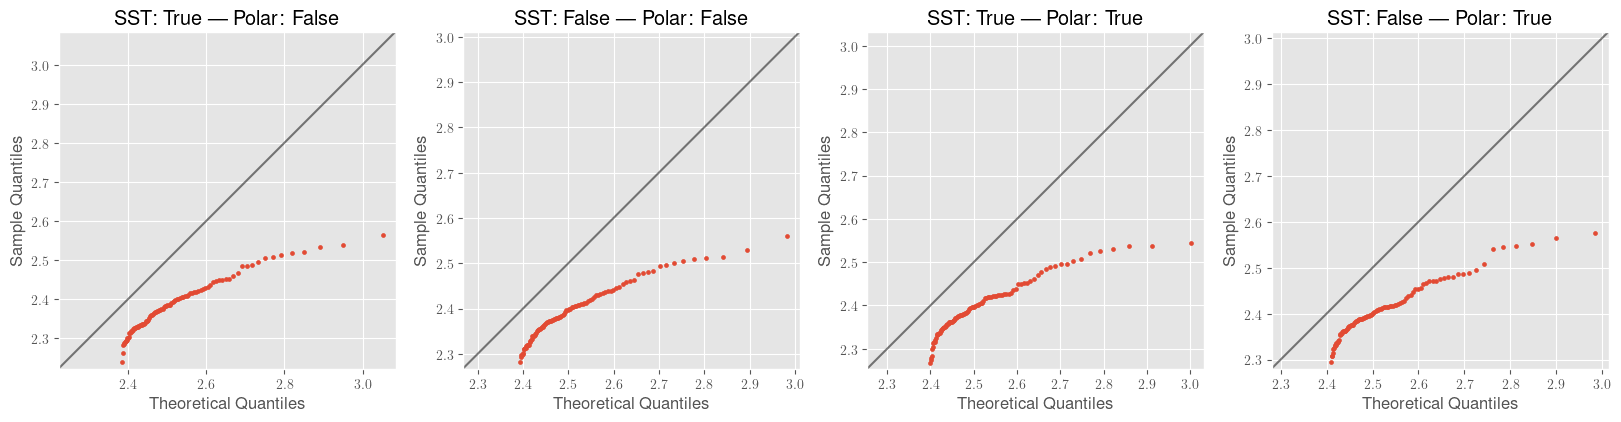

In [88]:
#axis_positions = [[0,0],[0,1],[1,0],[1,1]]
names = ['SST: True | Polar: False','SST: False | Polar: False','SST: True | Polar: True','SST: False | Polar: True']
num_quantiles = 100
# create figure
fig,axs = plt.subplots(1,4)
grouped_data = global_assumption_validation_by_replication.groupby('config_id')
fig.set_figwidth(20)
for ii, config_id in enumerate(config_ids):
    #x_position,y_position = axis_positions[ii]
    data = grouped_data.get_group(config_id)['Mahalanobis Distance'],
    sample_quantiles = [np.quantile(data,qq) for qq in np.linspace(0,0.99,num_quantiles)]

    mean = np.mean(data)
    std = np.std(data,ddof=1)
    theoretical_quantiles = [scipy.stats.chi2.ppf(qq, df = 2, loc = mean, scale = std) for qq in np.linspace(0,0.99,num_quantiles)]
    ax = axs[ii]
    ax.scatter(theoretical_quantiles,sample_quantiles,s=8)
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]), 
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.5)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_title(f'{names[ii]}')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')



2. Studentised residual Q-Q plot: Checking normality of the residuals in each dimension

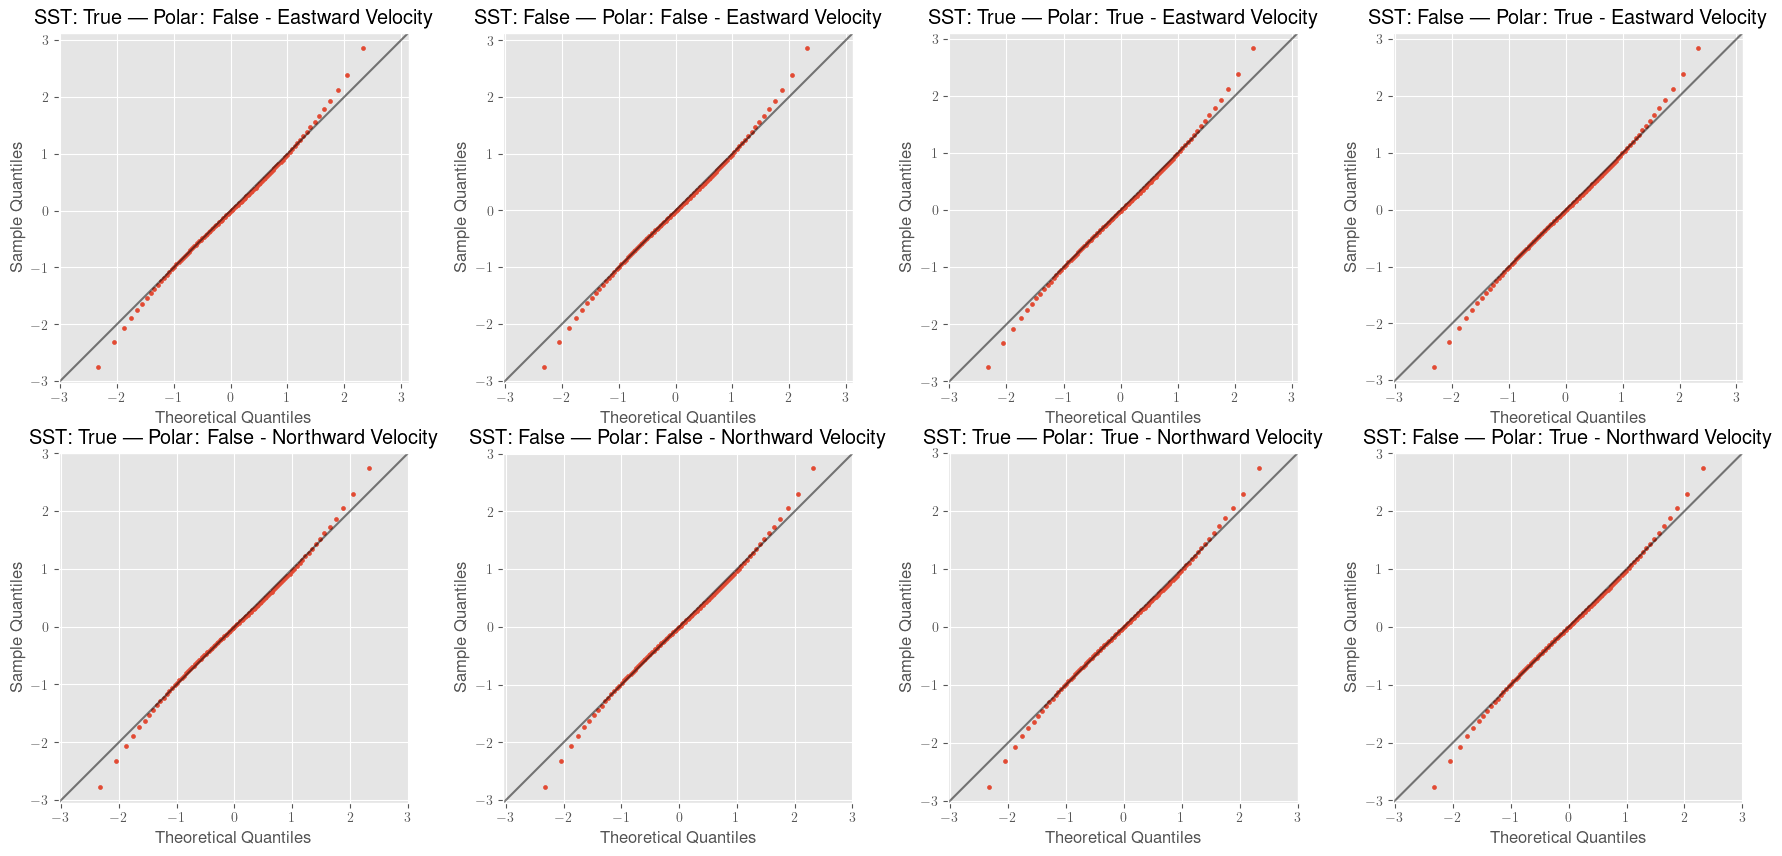

In [90]:
#axis_positions = [[0,0],[0,1],[1,0],[1,1]]
names = ['SST: True | Polar: False','SST: False | Polar: False','SST: True | Polar: True','SST: False | Polar: True']
directions = ['Eastward Velocity', 'Northward Velocity']
num_quantiles = 100
# create figure
fig,axs = plt.subplots(2,4)
grouped_data = studentised_residuals.groupby('config_id')
fig.set_figwidth(22)
fig.set_figheight(10)
for ii, config_id in enumerate(config_ids):
    #x_position,y_position = axis_positions[ii]
    for jj in range(2):
        data = grouped_data.get_group(config_id)[f'Studentised e_{jj+1}'],
        sample_quantiles = [np.quantile(data,qq) for qq in np.linspace(0,0.99,num_quantiles)]
        theoretical_quantiles = [scipy.stats.norm.ppf(qq) for qq in np.linspace(0,0.99,num_quantiles)]
        ax = axs[jj,ii]
        ax.scatter(theoretical_quantiles,sample_quantiles,s=8)
        lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]), 
        ]
        # now plot both limits against eachother
        ax.plot(lims, lims, 'k-', alpha=0.5)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_title(f'{names[ii]} - {directions[jj]}')
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')


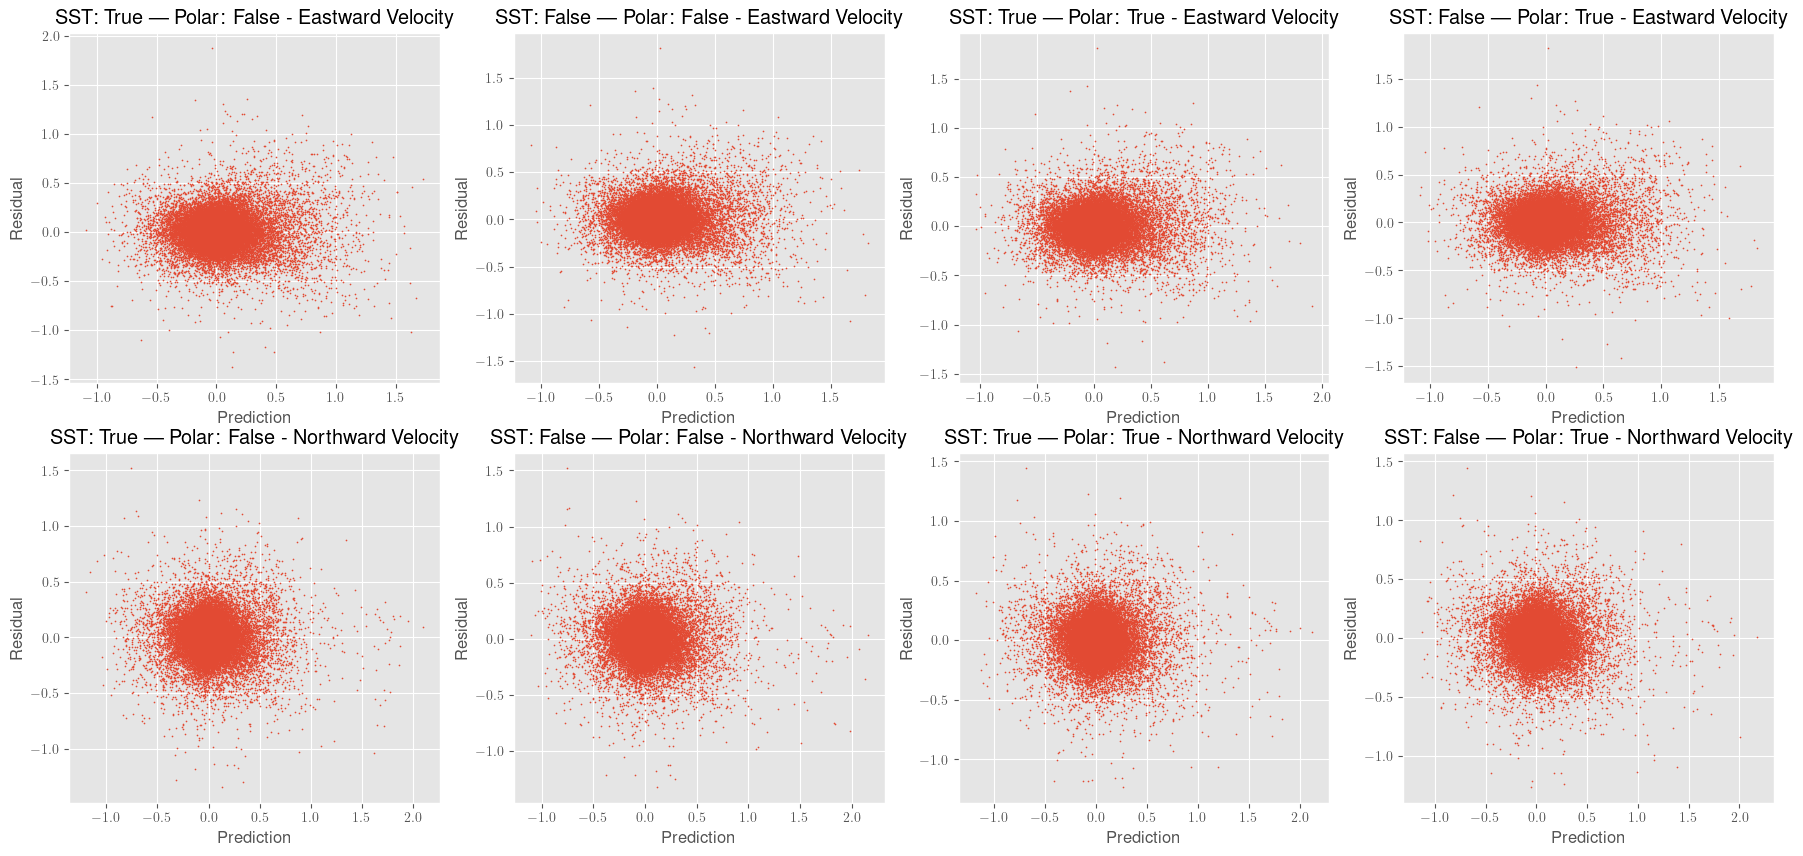

In [91]:
# create figure
fig,axs = plt.subplots(2,4)
fig.set_figwidth(22)
fig.set_figheight(10)
for ii, config_id in enumerate(config_ids):
    #x_position,y_position = axis_positions[ii]
    for jj in range(2):
        residuals = point_analysis_data.get_group((config_id,8))[f'e_{jj+1}']
        predictions = point_analysis_data.get_group((config_id,8))[f'mu_{jj+1}']
        ax = axs[jj,ii]
        ax.scatter(predictions,residuals,s=0.5)
        ax.set_title(f'{names[ii]} - {directions[jj]}')
        ax.set_xlabel('Prediction')
        ax.set_ylabel('Residual')

        

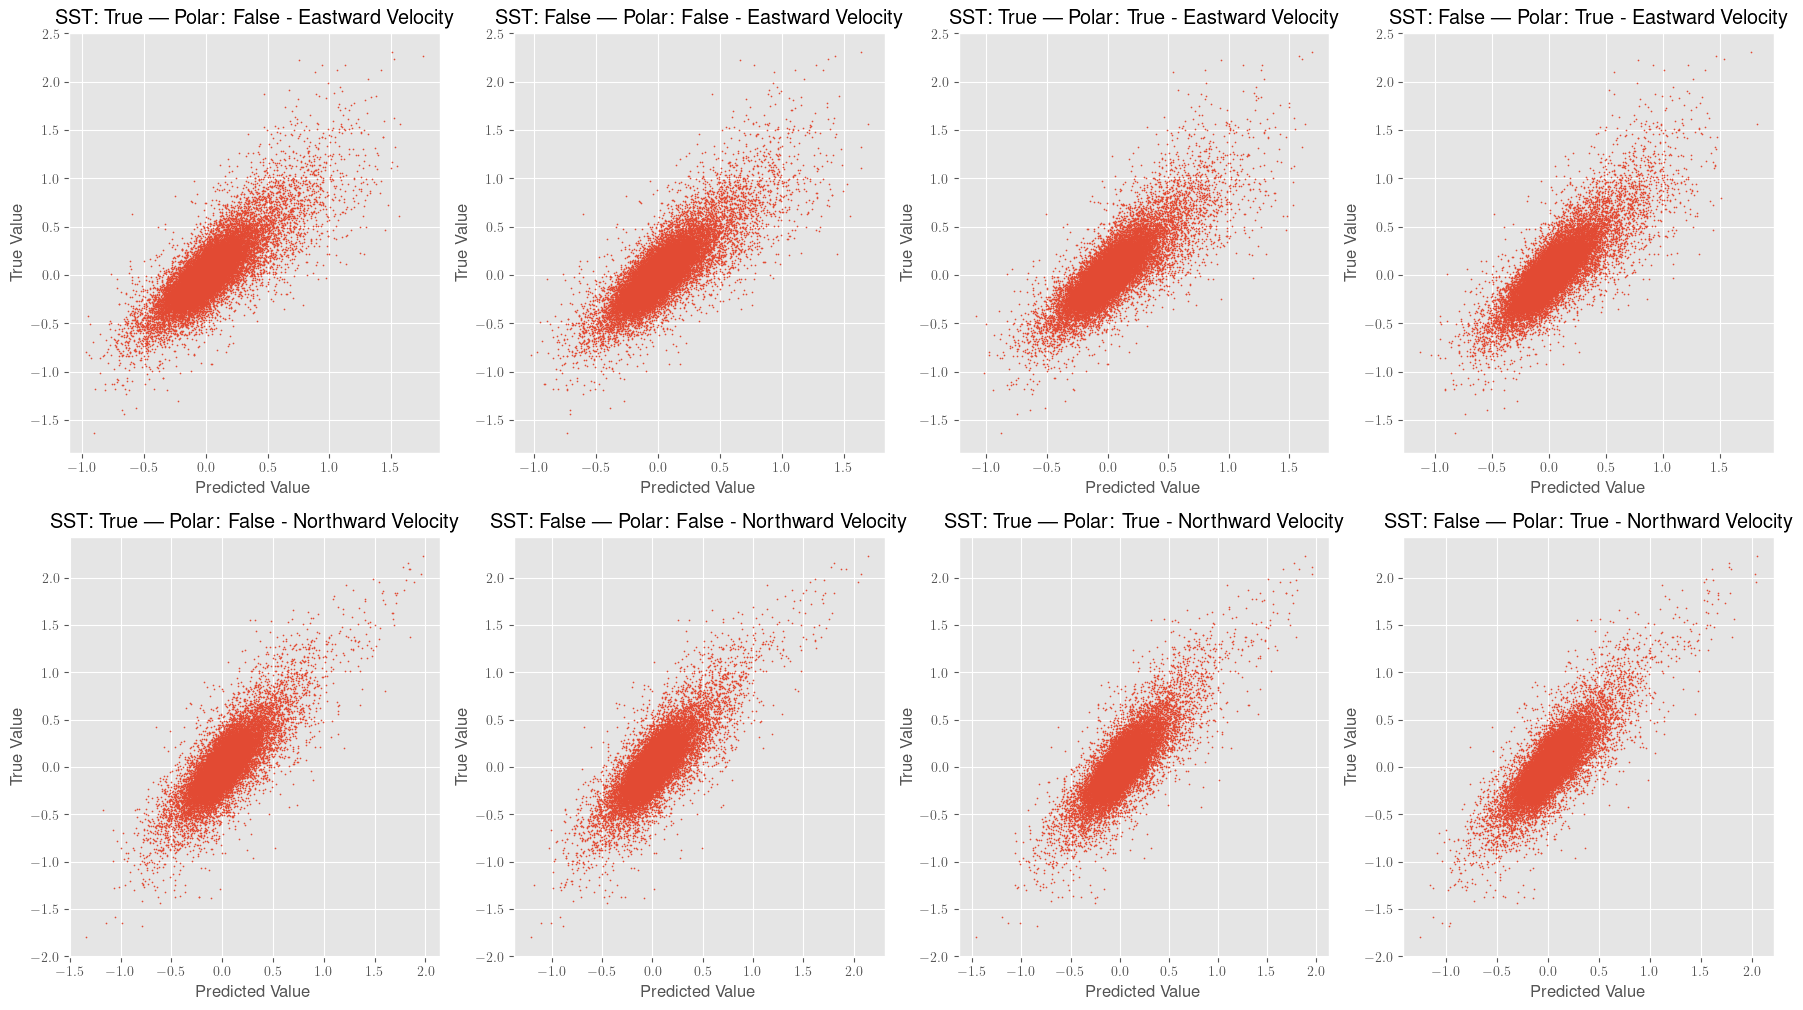

In [92]:
labels = ['u','v']
# create figure
fig,axs = plt.subplots(2,4)
fig.set_figwidth(22)
fig.set_figheight(12)
for ii, config_id in enumerate(config_ids):
    #x_position,y_position = axis_positions[ii]
    for jj in range(2):
        actual_values = point_analysis_data.get_group((config_id,1))[labels[jj]]
        predictions = point_analysis_data.get_group((config_id,1))[f'mu_{jj+1}']
        ax = axs[jj,ii]
        ax.scatter(predictions,actual_values,s=0.5)
        ax.set_title(f'{names[ii]} - {directions[jj]}')
        ax.set_xlabel('Predicted Value')
        ax.set_ylabel('True Value')
